In [4]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from tqdm import tqdm
plt.rcParams['font.size'] = 14

## 3

In [142]:
def get_pi(P):
    eigenvals, eigenvecs = np.linalg.eig(P)
    Q_inv = np.linalg.inv(eigenvecs)
    # getting eigenvector associated with lambda = 1
    temp = np.real(Q_inv[np.argsort(-eigenvals)[0]])        
    # normalizing eigenvector
    pi = temp/temp.sum()
    
    return pi

dist_tv = lambda a,b: 0.5*np.sum(np.absolute(a-b))

def get_plot_dtv(P, pi=None, ax=None, label=''):
    if pi is None:
        pi = get_pi(P)
    
    pi_0 = np.zeros(P.shape[0])
    pi_0[0] = 1

    diff = []
    powers = [10**i for i in range(4)]
    for power in powers:
        pi_t = pi_0@np.linalg.matrix_power(P, power)
        diff.append(dist_tv(pi_t, pi))
            
    if ax is None:
        fig, ax = plt.subplots(figsize=(12,6))
    
    ax.plot(powers, diff, label=label)
    ax.scatter(powers, diff)
    ax.grid(True)
    ax.set_xscale('log'), ax.set_yscale('log')
    ax.set_xlabel('Number of iterations'), ax.set_ylabel('$d_{tv}$', rotation=0)

    if ax is None:
        return fig, ax

    return ax
        
    

### 3.3.1 Grafo em Anel

In [107]:
N = 100
p = 1/2
filename='./temp/lista4_3_2_1.png'

def get_ring_model(N=100, p=0.5):
    P = np.zeros([N, N])
    for i in np.arange(N):
        for j in np.arange(N):
            if i == j:
                P[i][j] = p
                continue
            elif i == j+1 or i == j-1:
                P[i][j] = (1-p)/2
            elif i == N-1 and j == 0:
                P[i][j] = (1-p)/2
            elif j == N-1 and i == 0:
                P[i][j] = (1-p)/2
                
    return P

P = get_ring_model(N, p=0)

P.sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

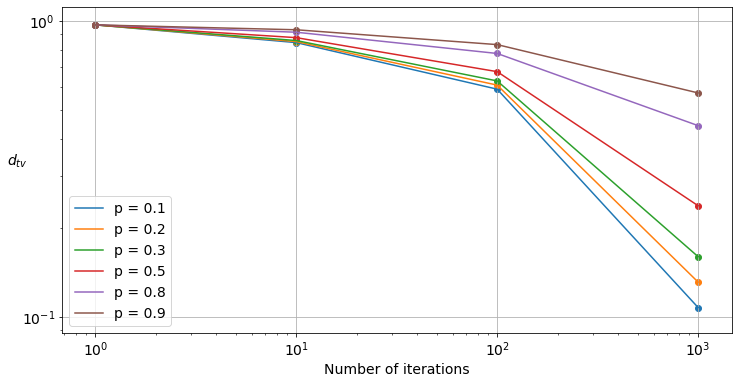

In [144]:
fig, ax = plt.subplots(ncols=1, nrows=1, sharex=True, figsize=(12, 6))

for i, p in enumerate([.1, .2, 0.3, 1/2, 0.8, 0.9]):
    P = get_ring_model(100, p)
    ax = get_plot_dtv(P, pi=None, ax=ax, label='p = ' + str(p))
    
ax.legend()
fig.savefig('./temp/lista4_ex3_item2_ring.png', bbox_inches='tight')

### 3.2.2 Grafo em Árvore Binária

In [29]:
class Node:
    
    def __init__(self, idx=None):
        self.idx = idx
        self.reset_children()
        self.reset_parent()
        
    def reset_children(self):
        self.children = []
        
    def reset_parent(self):
        self.parent = None
        
    def set_parent(self, parent):
        self.parent = parent
        
    def set_children(self, children):
        self.children = children
        
    def set_child(self, child):
        self.children.append(child)
        
    def get_n_parents(self):
        return 0 if self.parent == None else 1
        
    def get_n_children(self):
        return len(self.children)
        
    def has_parent(self, parent):
        return parent in self.parents
    
    def has_child(self, child):
        return child in self.children
    
    def get_neighbors(self):
        neighbors = []
        for child in self.children:
            neighbors.append(child)
            
        if self.parent is not None:
            neighbors.append(self.parent)
        
        return neighbors
        
    def __str__(self):
        text = ''
        if self.parent is not None:
            text += '{}-'.format(str(self.parent.idx))
        text += '(' + str(self.idx) + ')'
        
        if len(self.children) > 0:            
            text += '-' + '|'.join([str(child.idx) for child in self.children])
                
        return text
    
node = Node(3)
node.set_parent(Node(2))
node.set_children([Node(4), Node(4)])
node.set_child(Node(5))
print (node.has_child(node.children[0]))
print (node)
print (node.get_neighbors())

True
2-(3)-4|4|5
[<__main__.Node object at 0x00000241983E6CC0>, <__main__.Node object at 0x00000241983E6E48>, <__main__.Node object at 0x00000241983E6E10>, <__main__.Node object at 0x00000241983E6C88>]


In [149]:
class Tree:
    
    def __init__(self, n_levels = 3):
        self.n_levels = n_levels
        self.n_nodes = 0
        self.reset_tree()
        self.reset_edges()
            
    def reset_tree(self):
        self.levels = []
        for l in np.arange(self.n_levels):
            level = []
            if l == 0:                
                level.append(Node(l))
                self.n_nodes += 1
                    
            if l > 0 and l <= self.n_levels-1:
                for i in np.arange(2**(l)):
                    level.append(Node(self.n_nodes))
                    self.n_nodes += 1
        
            self.levels.append(level)
            
        self.set_children()
        
    def set_children(self):
        for l, level in enumerate(self.levels):
            if l == self.n_levels-1:                
                break
                
            for n, node in enumerate(level):
                children = [self.levels[l+1][2*n],
                            self.levels[l+1][2*n+1]]
                self.levels[l][n].set_children(children)
                self.levels[l+1][2*n].set_parent(self.levels[l][n])
                self.levels[l+1][2*n+1].set_parent(self.levels[l][n])
            
            #print (' [' + '   '.join([str(node) for node in level]) + ']')
        
    def reset_edges(self):
        self.edges = pd.DataFrame(columns=['source', 'target', 'prob'])
        
    def set_edge(self, source, target, prob):
        self.edges.loc[self.edges.shape[0]] = [source, target, prob]
        
    def __str__(self):
        for l, level in enumerate(self.levels):
            text = 'level ' + str(l) + ' [' + '  '.join([str(node) for node in level]) + ']'
            print (text)
    
        return ''
        
tree = Tree(6)
print (tree)

level 0 [(0)-1|2]
level 1 [0-(1)-3|4  0-(2)-5|6]
level 2 [1-(3)-7|8  1-(4)-9|10  2-(5)-11|12  2-(6)-13|14]
level 3 [3-(7)-15|16  3-(8)-17|18  4-(9)-19|20  4-(10)-21|22  5-(11)-23|24  5-(12)-25|26  6-(13)-27|28  6-(14)-29|30]
level 4 [7-(15)-31|32  7-(16)-33|34  8-(17)-35|36  8-(18)-37|38  9-(19)-39|40  9-(20)-41|42  10-(21)-43|44  10-(22)-45|46  11-(23)-47|48  11-(24)-49|50  12-(25)-51|52  12-(26)-53|54  13-(27)-55|56  13-(28)-57|58  14-(29)-59|60  14-(30)-61|62]
level 5 [15-(31)  15-(32)  16-(33)  16-(34)  17-(35)  17-(36)  18-(37)  18-(38)  19-(39)  19-(40)  20-(41)  20-(42)  21-(43)  21-(44)  22-(45)  22-(46)  23-(47)  23-(48)  24-(49)  24-(50)  25-(51)  25-(52)  26-(53)  26-(54)  27-(55)  27-(56)  28-(57)  28-(58)  29-(59)  29-(60)  30-(61)  30-(62)]



In [203]:
tree = Tree(6)
filename='./temp/lista4_ex3_item2_tree.png'


def get_tree_model(N=100, p=1/2):
    for i in np.arange(1e6):
        # finding most suitable number of levels
        if 2**i > N:
            n_levels = int(i)-1
            break
            
    tree = Tree(n_levels)
    P = np.zeros([tree.n_nodes, tree.n_nodes])
    
    for l, level in enumerate(tree.levels):
        for n, node in enumerate(level):
            P[node.idx][node.idx] = p
            n_neighbors = node.get_n_parents() + node.get_n_children()
            complement_prob = (1-p)/n_neighbors

            for neighbor in node.get_neighbors():
                P[node.idx][neighbor.idx] = complement_prob
            
    return P

get_tree_model(N=1000, p=0.3).shape

(511, 511)

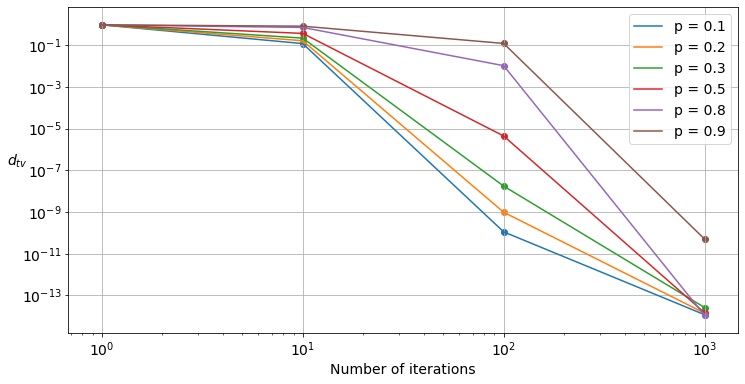

In [155]:
fig, ax = plt.subplots(ncols=1, nrows=1, sharex=True, figsize=(12, 6))

for i, p in enumerate([.1, .2, 0.3, 1/2, 0.8, 0.9]):
    P = get_tree_model(100, p)
    ax = get_plot_dtv(P, pi=None, ax=ax, label='p = ' + str(p))
    
ax.legend()
fig.savefig('./temp/lista4_ex3_item2_tree.png', bbox_inches='tight')

### 3.3.3 Grafo em Reticulado

In [86]:
class Point:
    def __init__(self, idx, x, y):
        self.idx = idx
        self.x = x
        self.y = y
        
    def __str__(self):
        return '{} ({}, {})'.format(self.idx, self.x, self.y)
    
    def equals(self, point):
        if point.x == self.x and point.y == self.y:
            return True
        return False

class Grid:
    
    def __init__(self, N):
        
        self.N = N
        self.grid = np.array([[Point(0, x, y) for y in np.arange(N)] for x in np.arange(N)])
        count = 0
        for row in self.grid:
            for point in row:
                point.idx = count
                count += 1
        self.clean_edges()
        
    def __str__(self):
        for row in self.grid:
            line = ' '.join([str(point) for point in row])
            print (line)
        
        return ''
    
    def clean_edges(self):
        self.edges = pd.DataFrame(columns=['source', 'target', 'prob'])
    
    def set_edge(self, source, target, prob):
        self.edges.loc[self.edges.shape[0]] = [source, target, prob]
        
    def get_index(self, x, y):
        return self.grid[x][y].idx
        
    def get_P(self):
        P = np.zeros([self.N**2, self.N**2])
        for _, edge in self.edges.iterrows():
            P[int(edge['source'])][int(edge['target'])] = edge['prob']
            
        return P
    
    def get_above(self, x, y):
        if y == self.N-1:
            return self.grid[x][0]
        
        return self.grid[x][y+1]
    
    def get_below(self, x, y):
        if y == 0:
            return self.grid[x][self.N-1]
        
        return self.grid[x][y-1]
    
    def get_right(self, x, y):
        if x == self.N-1:
            return self.grid[0][y]
        
        return self.grid[x+1][y]
    
    def get_left(self, x, y):
        if x == 0:
            return self.grid[self.N-1][y]
        
        return self.grid[x-1][y]


In [161]:
N = 100
filename='./temp/lista4_3_2_3.png'

def get_grid_model(N=100, p=0.5):

    g = Grid(int(np.sqrt(N)))

    g.clean_edges()
    for row in g.grid:
        for j in row:
            for column in g.grid:
                for i in column:
                    if i.equals(j):
                        g.set_edge(i.idx, j.idx, p)

                    if j.equals(g.get_left(i.x, i.y)) or j.equals(g.get_right(i.x, i.y)):
                        g.set_edge(i.idx, j.idx, (1-p)/4)

                    if j.equals(g.get_above(i.x, i.y)) or j.equals(g.get_below(i.x, i.y)):
                        g.set_edge(i.idx, j.idx, (1-p)/4)

    P = g.get_P()
    
    return P

get_grid_model(N=101, p=0.1)

array([[0.1  , 0.225, 0.   , ..., 0.   , 0.   , 0.   ],
       [0.225, 0.1  , 0.225, ..., 0.   , 0.   , 0.   ],
       [0.   , 0.225, 0.1  , ..., 0.   , 0.   , 0.   ],
       ...,
       [0.   , 0.   , 0.   , ..., 0.1  , 0.225, 0.   ],
       [0.   , 0.   , 0.   , ..., 0.225, 0.1  , 0.225],
       [0.   , 0.   , 0.   , ..., 0.   , 0.225, 0.1  ]])

Calculating eigenvector associated with $\pi$

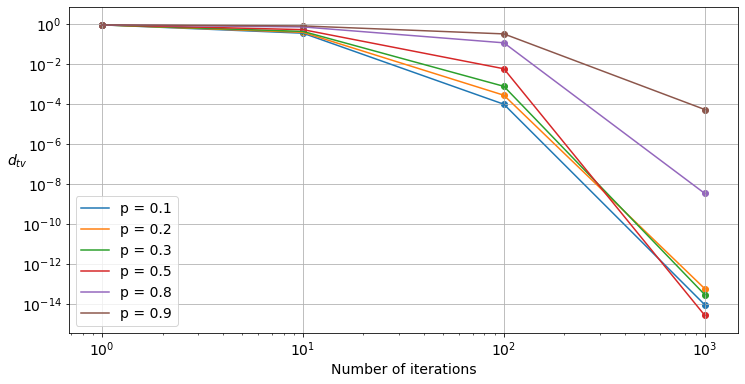

In [160]:
fig, ax = plt.subplots(ncols=1, nrows=1, sharex=True, figsize=(12, 6))

for i, p in enumerate([.1, .2, 0.3, 1/2, 0.8, 0.9]):
    P = get_grid_model(100, p)
    ax = get_plot_dtv(P, pi=None, ax=ax, label='p = ' + str(p))
    
ax.legend()
fig.savefig('./temp/lista4_ex3_item2_grid.png', bbox_inches='tight')

### 4 Tempo de Mistura

In [189]:
def get_mixture_time(P, pi, epsilon=1e-3):
    pi_0 = np.zeros(P.shape[0])
    pi_0[0] = 1

    iteration = 0    
    stop = False
    pi_t = pi_0@P
    while not stop:
        iteration += 1
        pi_t = pi_t@P
        dist = dist_tv(pi_t, pi)
        if dist <= epsilon:
            stop = True
            
        if iteration > 1e8:
            print ('Early stopping at ', iteration)
            
    return iteration

P = get_tree_model(4, p=0.5)
pi = get_pi(P)
print (pi.shape)
get_mixture_time(P, pi, epsilon=1e-4)

(63,)


75

In [215]:
%%time
df_times = pd.DataFrame(columns=['model', 'n', 'mixture_time'])
# df_times = df_times.query('model != "tree"').reset_index(drop=True)
for model in ['ring', 'tree', 'grid']:
# for model in ['tree']:
    print ('Processing mixture time for ', model)
    for n in tqdm([10, 50, 100, 300, 700, 1000]):
        if model == 'grid':
            P = get_grid_model(n, p=0.5)
        elif model == 'tree':
            P = get_tree_model(n, p=0.5)
        else:
            P = get_ring_model(n, p=0.5)
        
        pi = get_pi(P)
        mixture_time = get_mixture_time(P, pi, epsilon=1e-4)
        df_times.loc[df_times.shape[0]] = [model, n, mixture_time]
    
    df_times.query('model == @model').to_csv('./temp/df_mixture_time_{}.csv'.format(model), sep=';', index=None)
        
df_times.to_csv('./temp/df_mixture_time.csv', sep=';', index=None)

Processing mixture time for  ring


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [07:54<00:00, 135.46s/it]


Processing mixture time for  tree


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  4.59it/s]


Processing mixture time for  grid


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:41<00:00, 10.22s/it]


Wall time: 8min 37s


In [205]:
df_times

,model,n,mixture_time
0,ring,10,64
1,ring,50,1634
2,ring,100,6540
3,ring,300,58871
4,ring,700,320530
5,ring,1000,654145
6,grid,10,14
7,grid,50,67
8,grid,100,136
9,grid,300,393


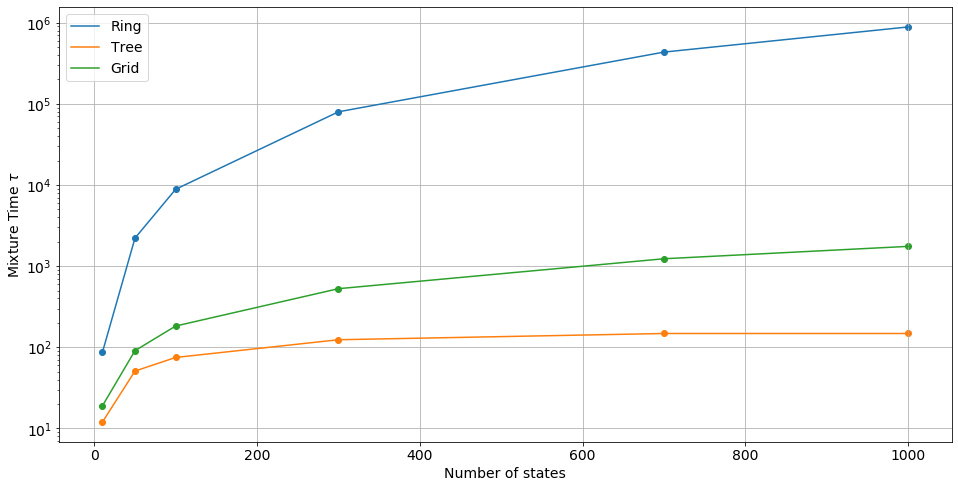

In [217]:
fig, ax = plt.subplots(figsize=(16,8))

for model in df_times['model'].unique():
    df_plot = df_times.query('model == @model')
    ax.plot(df_plot['n'], df_plot['mixture_time'], label=model.title())
    ax.scatter(df_plot['n'], df_plot['mixture_time'])
    
ax.grid(True)
ax.set_yscale('log')
ax.grid(True)
ax.set_xlabel('Number of states'), ax.set_ylabel('Mixture Time $\\tau$')
ax.legend()
fig.savefig('./temp/lista4_ex4.png', bbox_inches='tight')